## Imports

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(42)
torch.manual_seed(42)

<hr>

## Loading Files

In [17]:
X = np.load('/kaggle/input/active-learning-subset/tar_image_subset.npy')
y = np.load('/kaggle/input/active-learning-subset/label_target_subset.npy')

print(X.shape, y.shape)

(20000, 6, 28) (20000,)


In [18]:
# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
print(X_train.shape, X_val.shape)

(16000, 6, 28) (4000, 6, 28)


<hr>

## Dataset Class

In [19]:
class SimpleDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.int64)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = torch.tensor(self.images[idx])  # shape: (6, 28)
        y = torch.tensor(self.labels[idx])
        return {"x": x, "y": y}

In [20]:
# For evaluation
val_dataset = SimpleDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

<hr>

## Model

In [21]:
################ CNN Backbone
def conv_block(in_channels: int, out_channels: int, dropout_p=0.5) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5,padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
        nn.Dropout(p=dropout_p)
    )
 
 
class cnn_dropout(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()
        self.conv1 = conv_block(6, 64, dropout_p)
        self.conv2 = conv_block(64, 128, dropout_p)
        self.conv3 = conv_block(128, 256, dropout_p)
        self.conv4 = conv_block(256, 512, dropout_p)
        self.conv5 = conv_block(512, 1024, dropout_p)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.global_pool(x)
        return x.view(x.size(0), -1)
 
 
################ Fully connected network
class FC_dropout(nn.Module):
    def __init__(self,input_dim, dropout_p=0.5):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_p)
        self.fco = nn.Linear(input_dim, 3)

    def forward(self, x):
        x = self.dropout(x)
        return self.fco(x)

In [22]:
# Loading model weights
backbone_state = torch.load('/kaggle/input/active-learning-subset/backboneSiteA2019.pth')
fc_state = torch.load('/kaggle/input/active-learning-subset/fcSiteA2019.pth')

backbone_state = OrderedDict((k.replace('module.', ''), v) for k, v in backbone_state.items())
fc_state = OrderedDict((k.replace('module.', ''), v) for k, v in fc_state.items())

# Initialize and load models
backbone = cnn_dropout()
backbone.to(device)

fc = FC_dropout(1024)
fc.to(device)

backbone.load_state_dict(backbone_state)
fc.load_state_dict(fc_state)

<All keys matched successfully>

In [23]:
# Enable dropout at inference/prediction (MC dropout)
def enable_dropout(model):
    """Enable dropout layers during test time."""
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()  # Keep dropout in training mode

<hr>

## Evaluation Function

In [24]:
def eval_perf(dataloader, backbone, fc, device):
    backbone.eval()
    fc.eval()

    pred=[]
    gt=[]

    with torch.no_grad():
        for batch in dataloader:
            xt, yt = batch["x"].to(device), batch["y"].to(device)

            # Forward pass through backbone and FC head
            features = backbone(xt)
            outputs = fc(features)
            
            yt_pred = torch.argmax(outputs, dim=1)
            pred.extend(yt_pred.cpu().numpy())
            gt.extend(yt.cpu().numpy())

    # Convert to numpy arrays
    pred = np.array(pred)
    gt = np.array(gt)

    # Computing metrics
    f1s = sklearn.metrics.f1_score(gt, pred, average=None)
    acc = np.mean(pred == gt)
    avg_f1 = f1s.mean()

    # Set models back to train mode
    backbone.train()
    fc.train()

    return f1s, acc, avg_f1

<hr>

## Query Sampler (Aquisition Functions)

In [25]:
# Initialize pools
labeled_pool = set()
unlabeled_pool = set(range(len(X_train)))  # {0, 1, ..., 15999}

# ============= Predictive Entropy ============= 
def predictive_entropy_sampling(X, model_backbone, model_fc, k, device, unlabeled_pool, sim=20):
    model_backbone.eval()
    model_fc.eval()
    enable_dropout(model_backbone)
    enable_dropout(model_fc)

    indices = list(unlabeled_pool)
    X_pool = X[indices]
    mc_probs = []

    with torch.no_grad():
        for _ in tqdm(range(sim), desc='MC Dropout Simulations (PE)'):
            logits = []
            for i in range(0, len(X_pool), 32):
                x_batch = torch.tensor(X_pool[i:i+32]).float().to(device)
                feats = model_backbone(x_batch)
                out = model_fc(feats)
                logits.append(F.softmax(out, dim=1).cpu())
            probs = torch.cat(logits, dim=0)
            mc_probs.append(probs)

    mc_probs = torch.stack(mc_probs)  # Shape: [T, N, C]
    avg_probs = mc_probs.mean(dim=0)  # Shape: [N, C]
    entropy = -torch.sum(avg_probs * torch.log(avg_probs + 1e-8), dim=1)

    topk = torch.topk(entropy, k=k).indices
    return [indices[i.item()] for i in topk]

In [26]:
 history = {
        "rounds": [],
        "num_labeled": [],
        "accuracy": [],
        "avg_f1": [],
        "f1s": []
    }

<hr>

## Training Loop

In [27]:
def train(backbone, fc, train_loader, device, epochs=5):
    backbone.train()
    fc.train()

    optimizer = torch.optim.Adam(list(backbone.parameters()) + list(fc.parameters()), lr=1e-3)

    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            xt = batch["x"].to(device)
            yt = batch["y"].to(device)

            optimizer.zero_grad()

            features = backbone(xt)
            outputs = fc(features)
            loss = F.cross_entropy(outputs, yt)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            
        if (epoch+1)%5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

<hr>

## AL Pipeline Loop

In [29]:
num_rounds = 15
epochs = 50
query_size = 200 
sim = 30


for round_num in range(1, num_rounds + 1):
    print(f"\n--- Round {round_num} ---")

    # Cold start: Re-initialize model at every round
    # backbone = cnn_dropout().to(device)
    # fc = FC_dropout(1024).to(device)
    # backbone.load_state_dict(backbone_state)
    # fc.load_state_dict(fc_state)
    
    # 1. Query k samples
    queried_indices = predictive_entropy_sampling(
        X=X_train,
        model_backbone=backbone,
        model_fc=fc,
        k=query_size,
        device=device,
        unlabeled_pool=unlabeled_pool,
        sim = sim
    )

    # 2. Update pools
    new_indices = set(queried_indices) - labeled_pool  # avoid duplication
    labeled_pool.update(new_indices)
    unlabeled_pool.difference_update(new_indices)
    print('Length of Labeled Pool:', len(labeled_pool))
    print('Length of Unlabeled Pool:', len(unlabeled_pool))
    
    # 3. Build train loader
    train_dataset = SimpleDataset(X_train[list(labeled_pool)], y_train[list(labeled_pool)])
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # 4. Train + Evaluate
    train(backbone, fc, train_loader, device, epochs=epochs)
    f1s, acc, avg_f1 = eval_perf(val_dataloader, backbone, fc, device)
    
    print("Per-class F1 scores:", f1s)
    print(f"Overall Accuracy: {acc * 100:.2f}%")
    print(f"Average F1 Score: {avg_f1:.4f}")

    # 5. Update history
    history["rounds"].append(round_num)
    history["num_labeled"].append(len(labeled_pool))
    history["accuracy"].append(acc)
    history["avg_f1"].append(avg_f1)
    history["f1s"].append(f1s.tolist())


--- Round 1 ---


MC Dropout Simulations: 100%|██████████| 30/30 [00:30<00:00,  1.03s/it]


Length of Labeled Pool: 200
Length of Unlabeled Pool: 15800
Epoch 5/50, Loss: 1.2298
Epoch 10/50, Loss: 0.6255
Epoch 15/50, Loss: 0.3177
Epoch 20/50, Loss: 0.4846
Epoch 25/50, Loss: 0.2910
Epoch 30/50, Loss: 0.3393
Epoch 35/50, Loss: 0.3119
Epoch 40/50, Loss: 0.2753
Epoch 45/50, Loss: 0.2255
Epoch 50/50, Loss: 0.1762
Per-class F1 scores: [0.72105635 0.         0.73810994]
Overall Accuracy: 68.10%
Average F1 Score: 0.4864

--- Round 2 ---


MC Dropout Simulations: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]


Length of Labeled Pool: 400
Length of Unlabeled Pool: 15600
Epoch 5/50, Loss: 0.5379
Epoch 10/50, Loss: 0.4476
Epoch 15/50, Loss: 0.3715
Epoch 20/50, Loss: 0.4001
Epoch 25/50, Loss: 0.3352
Epoch 30/50, Loss: 0.3455
Epoch 35/50, Loss: 0.2915
Epoch 40/50, Loss: 0.3136
Epoch 45/50, Loss: 0.2698
Epoch 50/50, Loss: 0.2318
Per-class F1 scores: [0.74993522 0.28355958 0.79643473]
Overall Accuracy: 73.15%
Average F1 Score: 0.6100

--- Round 3 ---


MC Dropout Simulations: 100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


Length of Labeled Pool: 600
Length of Unlabeled Pool: 15400
Epoch 5/50, Loss: 0.3806
Epoch 10/50, Loss: 0.3550
Epoch 15/50, Loss: 0.3536
Epoch 20/50, Loss: 0.3103
Epoch 25/50, Loss: 0.2810
Epoch 30/50, Loss: 0.2818
Epoch 35/50, Loss: 0.2408
Epoch 40/50, Loss: 0.3075
Epoch 45/50, Loss: 0.2371
Epoch 50/50, Loss: 0.2531
Per-class F1 scores: [0.84190782 0.82791587 0.83240223]
Overall Accuracy: 83.62%
Average F1 Score: 0.8341

--- Round 4 ---


MC Dropout Simulations: 100%|██████████| 30/30 [00:29<00:00,  1.02it/s]


Length of Labeled Pool: 800
Length of Unlabeled Pool: 15200
Epoch 5/50, Loss: 0.3798
Epoch 10/50, Loss: 0.3777
Epoch 15/50, Loss: 0.3827
Epoch 20/50, Loss: 0.3377
Epoch 25/50, Loss: 0.3124
Epoch 30/50, Loss: 0.3189
Epoch 35/50, Loss: 0.3143
Epoch 40/50, Loss: 0.3117
Epoch 45/50, Loss: 0.2819
Epoch 50/50, Loss: 0.2580
Per-class F1 scores: [0.86237514 0.87411883 0.86335586]
Overall Accuracy: 86.42%
Average F1 Score: 0.8666

--- Round 5 ---


MC Dropout Simulations: 100%|██████████| 30/30 [00:28<00:00,  1.04it/s]


Length of Labeled Pool: 1000
Length of Unlabeled Pool: 15000
Epoch 5/50, Loss: 0.4548
Epoch 10/50, Loss: 0.3870
Epoch 15/50, Loss: 0.3804
Epoch 20/50, Loss: 0.3557
Epoch 25/50, Loss: 0.3560
Epoch 30/50, Loss: 0.3335
Epoch 35/50, Loss: 0.3588
Epoch 40/50, Loss: 0.3703
Epoch 45/50, Loss: 0.3365
Epoch 50/50, Loss: 0.2719
Per-class F1 scores: [0.87364238 0.88408644 0.86560649]
Overall Accuracy: 87.17%
Average F1 Score: 0.8744

--- Round 6 ---


MC Dropout Simulations: 100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


Length of Labeled Pool: 1200
Length of Unlabeled Pool: 14800
Epoch 5/50, Loss: 0.4121
Epoch 10/50, Loss: 0.4285
Epoch 15/50, Loss: 0.4148
Epoch 20/50, Loss: 0.3905
Epoch 25/50, Loss: 0.3634
Epoch 30/50, Loss: 0.3526
Epoch 35/50, Loss: 0.3356
Epoch 40/50, Loss: 0.3419
Epoch 45/50, Loss: 0.3733
Epoch 50/50, Loss: 0.3346
Per-class F1 scores: [0.87348735 0.88291747 0.871764  ]
Overall Accuracy: 87.40%
Average F1 Score: 0.8761

--- Round 7 ---


MC Dropout Simulations: 100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


Length of Labeled Pool: 1400
Length of Unlabeled Pool: 14600
Epoch 5/50, Loss: 0.4242
Epoch 10/50, Loss: 0.4172
Epoch 15/50, Loss: 0.4022
Epoch 20/50, Loss: 0.3853
Epoch 25/50, Loss: 0.3800
Epoch 30/50, Loss: 0.3750
Epoch 35/50, Loss: 0.3642
Epoch 40/50, Loss: 0.3576
Epoch 45/50, Loss: 0.3519
Epoch 50/50, Loss: 0.3475
Per-class F1 scores: [0.87765528 0.89103182 0.86991369]
Overall Accuracy: 87.62%
Average F1 Score: 0.8795

--- Round 8 ---


MC Dropout Simulations: 100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Length of Labeled Pool: 1600
Length of Unlabeled Pool: 14400
Epoch 5/50, Loss: 0.3966
Epoch 10/50, Loss: 0.4387
Epoch 15/50, Loss: 0.4195
Epoch 20/50, Loss: 0.3836
Epoch 25/50, Loss: 0.3667
Epoch 30/50, Loss: 0.3670
Epoch 35/50, Loss: 0.3533
Epoch 40/50, Loss: 0.3762
Epoch 45/50, Loss: 0.3660
Epoch 50/50, Loss: 0.3580
Per-class F1 scores: [0.87533875 0.87725975 0.8695919 ]
Overall Accuracy: 87.33%
Average F1 Score: 0.8741

--- Round 9 ---


MC Dropout Simulations: 100%|██████████| 30/30 [00:27<00:00,  1.10it/s]


Length of Labeled Pool: 1800
Length of Unlabeled Pool: 14200
Epoch 5/50, Loss: 0.4073
Epoch 10/50, Loss: 0.3903
Epoch 15/50, Loss: 0.4024
Epoch 20/50, Loss: 0.3750
Epoch 25/50, Loss: 0.3345
Epoch 30/50, Loss: 0.3787
Epoch 35/50, Loss: 0.3845
Epoch 40/50, Loss: 0.3546
Epoch 45/50, Loss: 0.3542
Epoch 50/50, Loss: 0.3599
Per-class F1 scores: [0.85563751 0.88697318 0.83607595]
Overall Accuracy: 85.20%
Average F1 Score: 0.8596

--- Round 10 ---


MC Dropout Simulations: 100%|██████████| 30/30 [00:26<00:00,  1.11it/s]


Length of Labeled Pool: 2000
Length of Unlabeled Pool: 14000
Epoch 5/50, Loss: 0.3710
Epoch 10/50, Loss: 0.3709
Epoch 15/50, Loss: 0.3875
Epoch 20/50, Loss: 0.3615
Epoch 25/50, Loss: 0.3577
Epoch 30/50, Loss: 0.3190
Epoch 35/50, Loss: 0.3259
Epoch 40/50, Loss: 0.3232
Epoch 45/50, Loss: 0.3431
Epoch 50/50, Loss: 0.3230
Per-class F1 scores: [0.88846572 0.8895293  0.88455681]
Overall Accuracy: 88.70%
Average F1 Score: 0.8875

--- Round 11 ---


MC Dropout Simulations: 100%|██████████| 30/30 [00:26<00:00,  1.13it/s]


Length of Labeled Pool: 2200
Length of Unlabeled Pool: 13800
Epoch 5/50, Loss: 0.3953
Epoch 10/50, Loss: 0.3622
Epoch 15/50, Loss: 0.3285
Epoch 20/50, Loss: 0.3498
Epoch 25/50, Loss: 0.3218
Epoch 30/50, Loss: 0.3249
Epoch 35/50, Loss: 0.3293
Epoch 40/50, Loss: 0.3117
Epoch 45/50, Loss: 0.3130
Epoch 50/50, Loss: 0.2901
Per-class F1 scores: [0.88496072 0.89390963 0.88589819]
Overall Accuracy: 88.65%
Average F1 Score: 0.8883

--- Round 12 ---


MC Dropout Simulations: 100%|██████████| 30/30 [00:26<00:00,  1.14it/s]


Length of Labeled Pool: 2400
Length of Unlabeled Pool: 13600
Epoch 5/50, Loss: 0.3619
Epoch 10/50, Loss: 0.3483
Epoch 15/50, Loss: 0.3319
Epoch 20/50, Loss: 0.3374
Epoch 25/50, Loss: 0.3073
Epoch 30/50, Loss: 0.3204
Epoch 35/50, Loss: 0.3217
Epoch 40/50, Loss: 0.3427
Epoch 45/50, Loss: 0.3023
Epoch 50/50, Loss: 0.2771
Per-class F1 scores: [0.89273169 0.89254598 0.88426209]
Overall Accuracy: 88.92%
Average F1 Score: 0.8898

--- Round 13 ---


MC Dropout Simulations: 100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


Length of Labeled Pool: 2600
Length of Unlabeled Pool: 13400
Epoch 5/50, Loss: 0.3355
Epoch 10/50, Loss: 0.3396
Epoch 15/50, Loss: 0.3355
Epoch 20/50, Loss: 0.3462
Epoch 25/50, Loss: 0.3188
Epoch 30/50, Loss: 0.3354
Epoch 35/50, Loss: 0.3096
Epoch 40/50, Loss: 0.3098
Epoch 45/50, Loss: 0.3072
Epoch 50/50, Loss: 0.3102
Per-class F1 scores: [0.8949374  0.8905804  0.88732824]
Overall Accuracy: 89.12%
Average F1 Score: 0.8909

--- Round 14 ---


MC Dropout Simulations: 100%|██████████| 30/30 [00:25<00:00,  1.18it/s]


Length of Labeled Pool: 2800
Length of Unlabeled Pool: 13200
Epoch 5/50, Loss: 0.3364
Epoch 10/50, Loss: 0.3243
Epoch 15/50, Loss: 0.3168
Epoch 20/50, Loss: 0.3264
Epoch 25/50, Loss: 0.3154
Epoch 30/50, Loss: 0.2910
Epoch 35/50, Loss: 0.3101
Epoch 40/50, Loss: 0.2921
Epoch 45/50, Loss: 0.2820
Epoch 50/50, Loss: 0.2862
Per-class F1 scores: [0.90345584 0.8995122  0.89816762]
Overall Accuracy: 90.08%
Average F1 Score: 0.9004

--- Round 15 ---


MC Dropout Simulations: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s]


Length of Labeled Pool: 3000
Length of Unlabeled Pool: 13000
Epoch 5/50, Loss: 0.3392
Epoch 10/50, Loss: 0.3164
Epoch 15/50, Loss: 0.3389
Epoch 20/50, Loss: 0.3151
Epoch 25/50, Loss: 0.3088
Epoch 30/50, Loss: 0.2970
Epoch 35/50, Loss: 0.2781
Epoch 40/50, Loss: 0.2786
Epoch 45/50, Loss: 0.2684
Epoch 50/50, Loss: 0.3051
Per-class F1 scores: [0.90008212 0.89296046 0.89244713]
Overall Accuracy: 89.60%
Average F1 Score: 0.8952


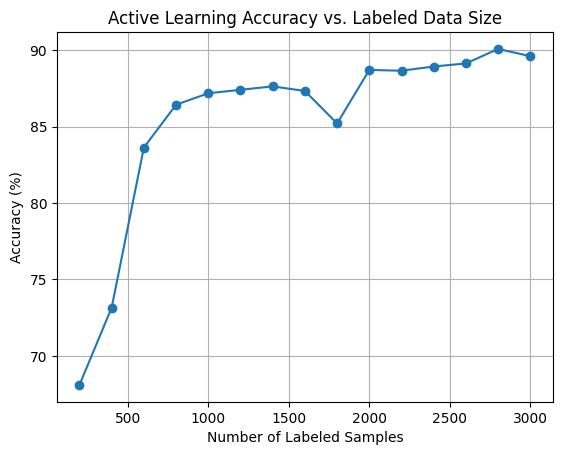

In [30]:
plt.plot(history["num_labeled"], [a * 100 for a in history["accuracy"]], marker="o")
plt.title("Active Learning Accuracy vs. Labeled Data Size")
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.show()

<hr>